c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 165s 19ms/step - accuracy: 0.3601 - loss: 1.0919 - val_accuracy: 0.4020 - val_loss: 1.0581
Epoch 2/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 163s 20ms/step - accuracy: 0.4318 - loss: 1.0434 - val_accuracy: 0.4248 - val_loss: 1.0337
Epoch 3/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.4453 - loss: 1.0294 - val_accuracy: 0.4243 - val_loss: 1.0240
Epoch 4/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 162s 20ms/step - accuracy: 0.4488 - loss: 1.0250 - val_accuracy: 0.4242 - val_loss: 1.0226
Epoch 5/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 165s 20ms/step - accuracy: 0.4490 - loss: 1.0237 - val_accuracy: 0.4181 - val_loss: 1.0314
Epoch 6/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.4509 - loss: 1.0222 - val_accuracy: 0.4218 - val_loss: 1.0281
Epoch 7/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.4512 - loss: 1.0210 - val_accuracy: 0.4241 - val_loss: 1.0184
Epoch 8/10
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 

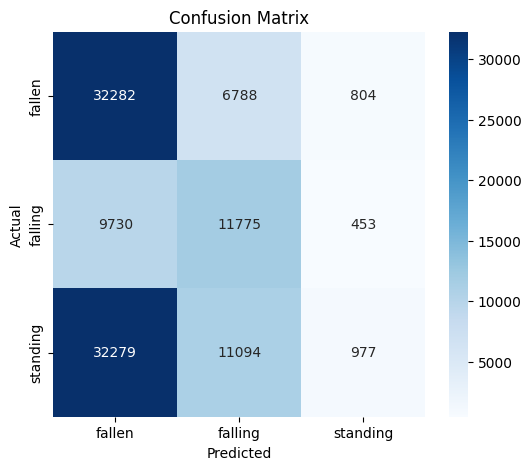

✅ 정확도(Accuracy): 0.4241
✅ 재현율(Recall): 0.4241


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 데이터 로드
file_path = "preprocessed_data_relabeled.csv"
df = pd.read_csv(file_path)

# 2. 학습에 필요한 컬럼 선택 (낙상 감지와 관련 없는 컬럼 제외)
# - `subject`: 피실험자 정보 → 학습 제외
# - `status`: 낙상 종류 (문자열) → 학습 제외
# - `interval`: 시간 정보 (이미 시계열 적용됨) → 학습 제외
# - `label`: 0(낙상), 1(비낙상) 구분, 보조용이지만 fall_stage 사용하므로 제외
categorical_columns = ['subject', 'status', 'interval', 'label']
numerical_columns = df.columns.difference(categorical_columns + ['fall_stage'])  # 학습에 사용할 수치형 데이터

df_numerical = df[numerical_columns]  # 학습에 사용할 수치형 데이터만 선택

# 3. 수치형 데이터 표준화 (모든 수치형 피처에 적용)
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

# 4. `fall_stage` 문자열을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
df['fall_stage'] = label_encoder.fit_transform(df['fall_stage'])  # 'standing', 'falling', 'fallen' → 0, 1, 2

# 5. 학습 데이터 생성 (feature, target)
X = df_numerical_scaled.values  # 특징 데이터
y = df['fall_stage'].values  # 타겟 라벨

# 6. Train/Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7. **SMOTE 적용 (Train 데이터에만)**
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 8. 다중 클래스 라벨을 위한 One-Hot Encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# 9. CNN+LSTM 모델 구성 (낙상 감지 최적화)
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_resampled.shape[1], 1)), 
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train_resampled_categorical.shape[1], activation='softmax')  # 다중 클래스 분류
])

# 10. 모델 컴파일 및 학습 (조기 종료 추가)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled_categorical, 
                    validation_data=(X_test, y_test_categorical), 
                    epochs=10, batch_size=64, verbose=1, callbacks=[early_stopping])

# 11. 모델 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# 12. Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 13. 결과 출력
print(f"✅ 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ 재현율(Recall): {recall:.4f}")


In [15]:
df.columns

Index(['Unnamed: 0', 'subject', 'label', 'status', 'fall_stage', 'interval',
       'ax_kurtosis', 'ax_spectral_entropy', 'ax_time_energy',
       'ax_activity_count', 'ay_kurtosis', 'ay_spectral_entropy',
       'ay_time_energy', 'ay_activity_count', 'az_kurtosis',
       'az_spectral_entropy', 'az_time_energy', 'az_activity_count', 'BPM',
       'NN50', 'RMSSD', 'SDSD', 'w_mean', 'w_median', 'w_std', 'w_mad',
       'w_skew', 'x_mean', 'x_median', 'x_std', 'x_mad', 'x_skew', 'y_mean',
       'y_median', 'y_std', 'y_mad', 'y_skew', 'z_mean', 'z_median', 'z_std',
       'z_mad', 'z_skew', 'ax_mean', 'ax_median', 'ax_std', 'ax_mad',
       'ax_skew', 'ay_mean', 'ay_median', 'ay_std', 'ay_mad', 'ay_skew',
       'az_mean', 'az_median', 'az_std', 'az_mad', 'az_skew'],
      dtype='object')

c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
4158/4158 ━━━━━━━━━━━━━━━━━━━━ 106s 24ms/step - accuracy: 0.3468 - loss: 1.0970 - val_accuracy: 0.3648 - val_loss: 1.0825
Epoch 2/8
4158/4158 ━━━━━━━━━━━━━━━━━━━━ 95s 23ms/step - accuracy: 0.3944 - loss: 1.0759 - val_accuracy: 0.4113 - val_loss: 1.0591
Epoch 3/8
4158/4158 ━━━━━━━━━━━━━━━━━━━━ 97s 23ms/step - accuracy: 0.4158 - loss: 1.0576 - val_accuracy: 0.4141 - val_loss: 1.0562
Epoch 4/8
4158/4158 ━━━━━━━━━━━━━━━━━━━━ 102s 24ms/step - accuracy: 0.4238 - loss: 1.0499 - val_accuracy: 0.4133 - val_loss: 1.0545
Epoch 5/8
4158/4158 ━━━━━━━━━━━━━━━━━━━━ 95s 23ms/step - accuracy: 0.4291 - loss: 1.0440 - val_accuracy: 0.4202 - val_loss: 1.0390
Epoch 6/8
4158/4158 ━━━━━━━━━━━━━━━━━━━━ 98s 24ms/step - accuracy: 0.4334 - loss: 1.0410 - val_accuracy: 0.4193 - val_loss: 1.0410
Epoch 7/8
4158/4158 ━━━━━━━━━━━━━━━━━━━━ 99s 24ms/step - accuracy: 0.4358 - loss: 1.0392 - val_accuracy: 0.4214 - val_loss: 1.0395
3319/3319 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step


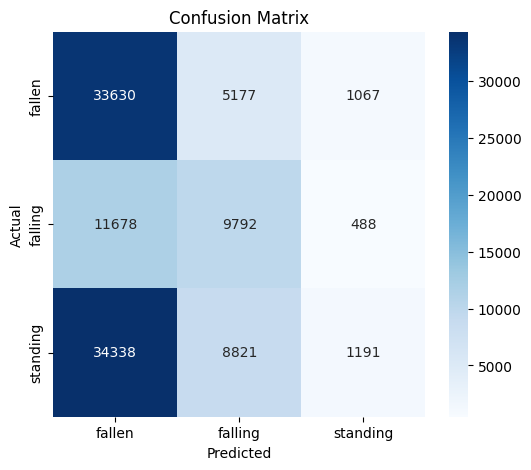

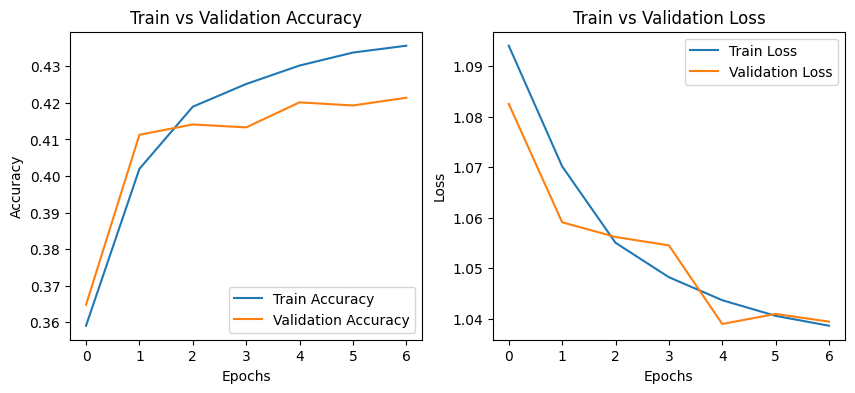

✅ 정확도(Accuracy): 0.4202
✅ 'falling' 클래스에 대한 재현율(Recall): 0.4459


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 로드
file_path = "preprocessed_data_relabeled.csv"
df = pd.read_csv(file_path)
df = df[df['status'].str.contains('fall')]

# 학습에 필요한 컬럼 선택 (불필요한 컬럼 제외)
categorical_columns = ['subject', 'status', 'interval', 'label']
numerical_columns = df.columns.difference(categorical_columns + ['fall_stage'])

df_numerical = df[numerical_columns]

# 수치형 데이터 표준화
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

# `fall_stage` 문자열을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
df['fall_stage'] = label_encoder.fit_transform(df['fall_stage'])

# 학습 데이터 생성 (feature, target)
X = df_numerical_scaled.values  # 특징 데이터
y = df['fall_stage'].values  # 타겟 라벨

# Train/Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# **SMOTE 적용 (Train 데이터에만)**
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 다중 클래스 라벨을 위한 One-Hot Encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# **CNN+LSTM 모델 구성 (학습 속도 최적화)**
model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train_resampled.shape[1], 1)),  # 필터 수 감소
    Dropout(0.2),
    LSTM(16, return_sequences=True),  # LSTM 노드 개수 감소
    LSTM(8),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(y_train_resampled_categorical.shape[1], activation='softmax')  # 다중 클래스 분류
])

# 모델 컴파일 및 학습 (조기 종료 추가)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  # patience 감소

history = model.fit(X_train_resampled, y_train_resampled_categorical, 
                    validation_data=(X_test, y_test_categorical), 
                    epochs=8, batch_size=128, verbose=1, callbacks=[early_stopping])  # 배치 크기 증가, 에포크 감소

# 모델 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# 'falling' 클래스에 대한 재현율(Recall) 계산
falling_index = list(label_encoder.classes_).index('falling')  # 'falling' 클래스의 인덱스 찾기
falling_recall = recall_score(y_true_classes, y_pred_classes, labels=[falling_index], average='weighted')

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 학습 및 검증 정확도 그래프
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# 학습 및 검증 손실(loss) 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()

# 결과 출력
print(f"✅ 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ 'falling' 클래스에 대한 재현율(Recall): {falling_recall:.4f}")


Epoch 1/10


c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4018/4018 ━━━━━━━━━━━━━━━━━━━━ 101s 24ms/step - accuracy: 0.3746 - loss: 1.0859 - val_accuracy: 0.4267 - val_loss: 1.0410
Epoch 2/10
4018/4018 ━━━━━━━━━━━━━━━━━━━━ 99s 25ms/step - accuracy: 0.4193 - loss: 1.0470 - val_accuracy: 0.4311 - val_loss: 1.0305
Epoch 3/10
4018/4018 ━━━━━━━━━━━━━━━━━━━━ 101s 25ms/step - accuracy: 0.4308 - loss: 1.0323 - val_accuracy: 0.4259 - val_loss: 1.0314
Epoch 4/10
4018/4018 ━━━━━━━━━━━━━━━━━━━━ 107s 27ms/step - accuracy: 0.4341 - loss: 1.0284 - val_accuracy: 0.4288 - val_loss: 1.0285
Epoch 5/10
4018/4018 ━━━━━━━━━━━━━━━━━━━━ 103s 26ms/step - accuracy: 0.4384 - loss: 1.0248 - val_accuracy: 0.4304 - val_loss: 1.0240
Epoch 6/10
4018/4018 ━━━━━━━━━━━━━━━━━━━━ 108s 27ms/step - accuracy: 0.4387 - loss: 1.0229 - val_accuracy: 0.4297 - val_loss: 1.0245
Epoch 7/10
4018/4018 ━━━━━━━━━━━━━━━━━━━━ 103s 26ms/step - accuracy: 0.4404 - loss: 1.0221 - val_accuracy: 0.4236 - val_loss: 1.0287
3319/3319 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


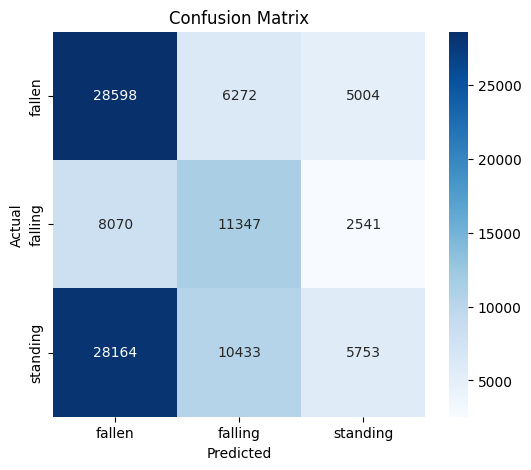

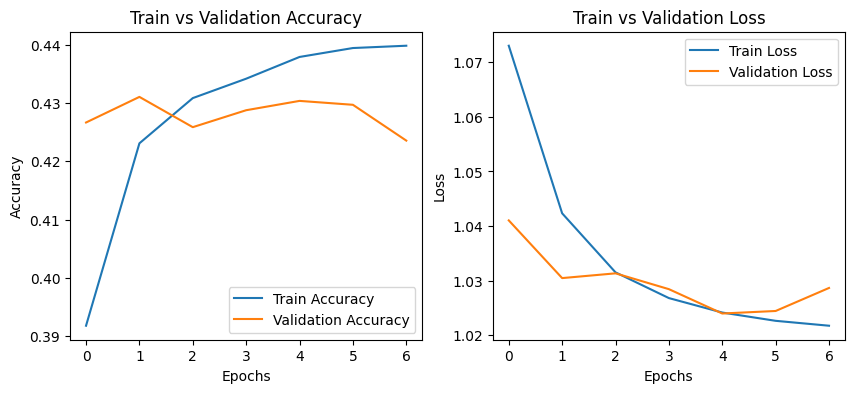

✅ 정확도(Accuracy): 0.4304
✅ 'falling' 클래스에 대한 재현율(Recall): 0.5168

🔍 Classification Report:
               precision    recall  f1-score   support

      fallen       0.44      0.72      0.55     39874
     falling       0.40      0.52      0.45     21958
    standing       0.43      0.13      0.20     44350

    accuracy                           0.43    106182
   macro avg       0.43      0.45      0.40    106182
weighted avg       0.43      0.43      0.38    106182



In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 데이터 로드
file_path = "preprocessed_data_relabeled.csv"
df = pd.read_csv(file_path)

# 2. 학습에 필요한 컬럼 선택 (불필요한 컬럼 제거)
categorical_columns = ['subject', 'status', 'interval', 'label']
numerical_columns = df.columns.difference(categorical_columns + ['fall_stage'])

df_numerical = df[numerical_columns]

# 3. 수치형 데이터 표준화
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

# 4. `fall_stage` 문자열을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
df['fall_stage'] = label_encoder.fit_transform(df['fall_stage'])

# 5. 학습 데이터 생성 (feature, target)
X = df_numerical_scaled.values
y = df['fall_stage'].values

# 6. Train/Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7. **falling 클래스만 Oversampling 적용**
falling_index = list(label_encoder.classes_).index('falling')
oversampler = RandomOverSampler(sampling_strategy={falling_index: int(np.max(np.bincount(y_train)))}, random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# 8. One-Hot Encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# 9. CNN+LSTM 모델 구성 (최적화 버전)
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_resampled.shape[1], 1)), 
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(y_train_resampled_categorical.shape[1], activation='softmax')  # 다중 클래스 분류
])

# 10. 모델 컴파일 및 학습 (조기 종료 추가)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled_categorical, 
                    validation_data=(X_test, y_test_categorical), 
                    epochs=10, batch_size=128, verbose=1, callbacks=[early_stopping])

# 11. 모델 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# 'falling' 클래스에 대한 재현율(Recall) 계산
falling_recall = recall_score(y_true_classes, y_pred_classes, labels=[falling_index], average='weighted')

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 학습 및 검증 정확도 & 손실 그래프
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()

# 결과 출력
print(f"✅ 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ 'falling' 클래스에 대한 재현율(Recall): {falling_recall:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


In [3]:
features = ['ax_kurtosis', 'ax_spectral_entropy',
   'ax_time_energy', 'ax_activity_count', 'ay_kurtosis',
   'ay_spectral_entropy', 'ay_time_energy', 'ay_activity_count',
   'az_kurtosis', 'az_spectral_entropy', 'az_time_energy',
   'az_activity_count', 'BPM', 'NN50', 'RMSSD', 'SDSD', 'w_mean',
   'w_median', 'w_std', 'w_mad', 'w_skew', 'x_mean', 'x_median', 'x_std',
   'x_mad', 'x_skew', 'y_mean', 'y_median', 'y_std', 'y_mad', 'y_skew',
   'z_mean', 'z_median', 'z_std', 'z_mad', 'z_skew', 'ax_mean',
   'ax_median', 'ax_std', 'ax_mad', 'ax_skew', 'ay_mean', 'ay_median',
   'ay_std', 'ay_mad', 'ay_skew', 'az_mean', 'az_median', 'az_std',
   'az_mad', 'az_skew','label']
# Compute correlation matrix
correlation_matrix = df[features].corr()
# label과의 절대 상관계수 값이 가장 큰 10개 feature 선택
top_10_correlated_features = correlation_matrix['label'].abs().sort_values(ascending=False).iloc[1:11]

# 결과 출력
print(top_10_correlated_features)


ax_spectral_entropy   NaN
ax_time_energy        NaN
ax_activity_count     NaN
ay_kurtosis           NaN
ay_spectral_entropy   NaN
ay_time_energy        NaN
ay_activity_count     NaN
az_kurtosis           NaN
az_spectral_entropy   NaN
az_time_energy        NaN
Name: label, dtype: float64

In [4]:
print(top_10_correlated_features)

ax_spectral_entropy   NaN
ax_time_energy        NaN
ax_activity_count     NaN
ay_kurtosis           NaN
ay_spectral_entropy   NaN
ay_time_energy        NaN
ay_activity_count     NaN
az_kurtosis           NaN
az_spectral_entropy   NaN
az_time_energy        NaN
Name: label, dtype: float64


🔍 선택된 Feature: ['RMSSD' 'ax_kurtosis' 'ax_mean' 'ax_median' 'ax_time_energy' 'ay_mean'
 'ay_median' 'ay_time_energy' 'az_kurtosis' 'w_mean' 'w_median' 'x_mean'
 'x_median' 'x_skew' 'y_mean' 'y_median' 'y_std' 'z_mad' 'z_mean'
 'z_median']
Epoch 1/20


c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8036/8036 ━━━━━━━━━━━━━━━━━━━━ 91s 11ms/step - accuracy: 0.3917 - loss: 1.0710 - val_accuracy: 0.4206 - val_loss: 1.0341
Epoch 2/20
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - accuracy: 0.4362 - loss: 1.0264 - val_accuracy: 0.4289 - val_loss: 1.0278
Epoch 3/20
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.4408 - loss: 1.0206 - val_accuracy: 0.4156 - val_loss: 1.0368
Epoch 4/20
8036/8036 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.4423 - loss: 1.0190 - val_accuracy: 0.4192 - val_loss: 1.0293
3319/3319 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


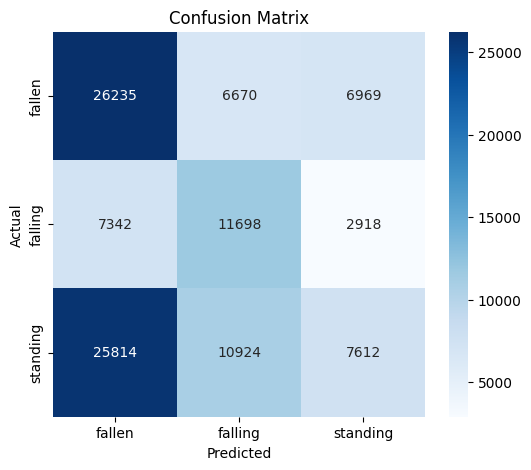

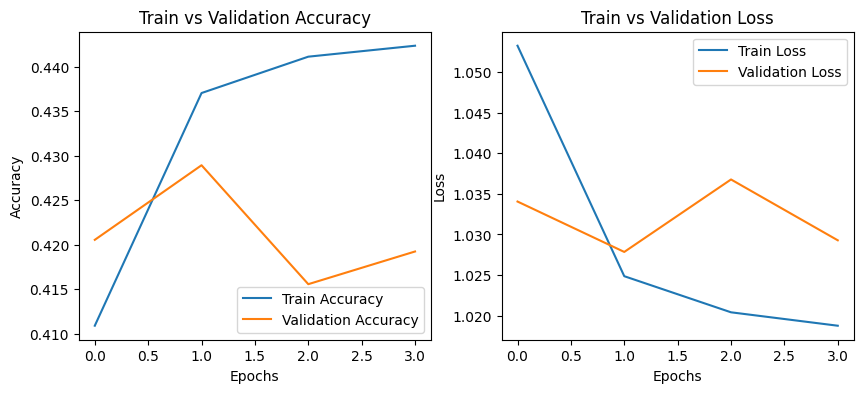

✅ 정확도(Accuracy): 0.4289
✅ 'falling' 클래스에 대한 재현율(Recall): 0.5327

🔍 Classification Report:
               precision    recall  f1-score   support

      fallen       0.44      0.66      0.53     39874
     falling       0.40      0.53      0.46     21958
    standing       0.43      0.17      0.25     44350

    accuracy                           0.43    106182
   macro avg       0.43      0.45      0.41    106182
weighted avg       0.43      0.43      0.40    106182



In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 1. 데이터 로드
file_path = "preprocessed_data_relabeled.csv"
df = pd.read_csv(file_path)
df.drop(columns='Unnamed: 0', inplace=True)
df = df[df['status'].str.contains('fall')]

# 2. 학습에 필요한 컬럼 선택 (불필요한 컬럼 제거)
categorical_columns = ['subject', 'status', 'interval', 'label']
numerical_columns = df.columns.difference(categorical_columns + ['fall_stage'])
df_numerical = df[numerical_columns]


# 3. 수치형 데이터 표준화
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

# 4. `fall_stage` 문자열을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
df['fall_stage'] = label_encoder.fit_transform(df['fall_stage'].astype(str))

# 5. 학습 데이터 생성 (feature, target)
X = df_numerical_scaled.values
y = df['fall_stage'].values

# 6. Train/Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7. **Feature Importance 기반 선택 (Random Forest 사용)**
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 중요도가 높은 Feature 선택
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# 선택된 Feature 확인
selected_features = np.array(numerical_columns)[selector.get_support()]
print(f"🔍 선택된 Feature: {selected_features}")

# 8. **falling 클래스만 Oversampling 적용**
if falling_index in y_train:
    oversampler = RandomOverSampler(sampling_strategy={falling_index: int(np.max(np.bincount(y_train)))}, random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_selected, y_train)
else:
    X_train_resampled, y_train_resampled = X_train_selected, y_train


# 9. One-Hot Encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# 10. CNN+LSTM 모델 구성 (최적화 버전)
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_resampled.shape[1], 1)), 
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(y_train_resampled_categorical.shape[1], activation='softmax')  # 다중 클래스 분류
])

# 11. 모델 컴파일 및 학습 (조기 종료 추가)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled_categorical, 
                    validation_data=(X_test_selected, y_test_categorical), 
                    epochs=20, batch_size=64, verbose=1, callbacks=[early_stopping])

# 12. 모델 평가
y_pred = model.predict(X_test_selected)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# 'falling' 클래스에 대한 재현율(Recall) 계산
falling_recall = recall_score(y_true_classes, y_pred_classes, labels=[falling_index], average='weighted')

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 학습 및 검증 정확도 & 손실 그래프
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()

# 결과 출력
print(f"✅ 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ 'falling' 클래스에 대한 재현율(Recall): {falling_recall:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

Epoch 1/20


c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6637/6637 ━━━━━━━━━━━━━━━━━━━━ 162s 24ms/step - accuracy: 0.4189 - loss: 1.0477 - val_accuracy: 0.4378 - val_loss: 1.0037
Epoch 2/20
6637/6637 ━━━━━━━━━━━━━━━━━━━━ 160s 24ms/step - accuracy: 0.4363 - loss: 1.0061 - val_accuracy: 0.4442 - val_loss: 0.9933
Epoch 3/20
6637/6637 ━━━━━━━━━━━━━━━━━━━━ 159s 24ms/step - accuracy: 0.4409 - loss: 0.9964 - val_accuracy: 0.4456 - val_loss: 0.9929
Epoch 4/20
6637/6637 ━━━━━━━━━━━━━━━━━━━━ 162s 24ms/step - accuracy: 0.4416 - loss: 0.9949 - val_accuracy: 0.4421 - val_loss: 0.9899
Epoch 5/20
6637/6637 ━━━━━━━━━━━━━━━━━━━━ 163s 24ms/step - accuracy: 0.4448 - loss: 0.9934 - val_accuracy: 0.4484 - val_loss: 0.9874
Epoch 6/20
6637/6637 ━━━━━━━━━━━━━━━━━━━━ 163s 25ms/step - accuracy: 0.4441 - loss: 0.9926 - val_accuracy: 0.4435 - val_loss: 0.9882
Epoch 7/20
6637/6637 ━━━━━━━━━━━━━━━━━━━━ 164s 25ms/step - accuracy: 0.4459 - loss: 0.9897 - val_accuracy: 0.4486 - val_loss: 0.9874
Epoch 8/20
6637/6637 ━━━━━━━━━━━━━━━━━━━━ 164s 25ms/step - accuracy: 0.4456 - lo

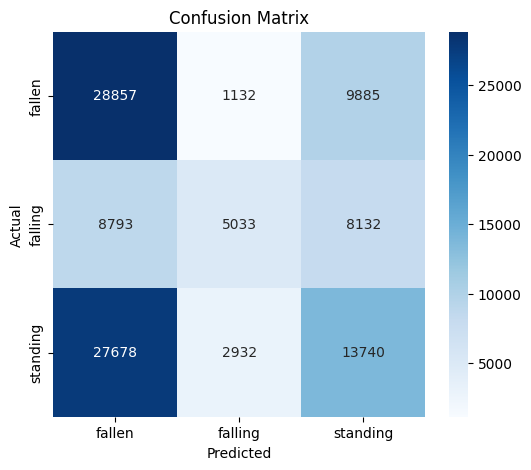

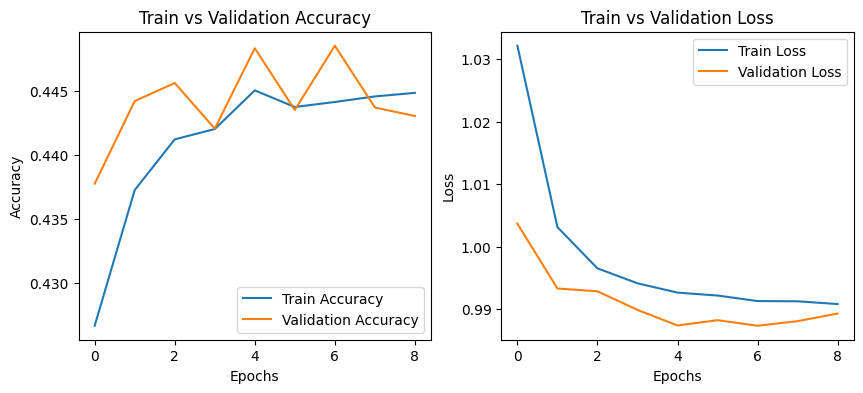

✅ 정확도(Accuracy): 0.4486
✅ 'falling' 클래스에 대한 재현율(Recall): 0.2292

🔍 Classification Report:
               precision    recall  f1-score   support

      fallen       0.44      0.72      0.55     39874
     falling       0.55      0.23      0.32     21958
    standing       0.43      0.31      0.36     44350

    accuracy                           0.45    106182
   macro avg       0.48      0.42      0.41    106182
weighted avg       0.46      0.45      0.42    106182



In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 1. 데이터 로드
file_path = "preprocessed_data_relabeled.csv"
df = pd.read_csv(file_path)
df.drop(columns='Unnamed: 0', inplace=True)
df = df[df['status'].str.contains('fall')]

# 2. 학습에 필요한 컬럼 선택 (불필요한 컬럼 제거)
categorical_columns = ['subject', 'status', 'interval', 'label']
numerical_columns = df.columns.difference(categorical_columns + ['fall_stage'])
df_numerical = df[numerical_columns]


# 3. 수치형 데이터 표준화
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

# 4. `fall_stage` 문자열을 숫자로 변환 (Label Encoding)
label_encoder = LabelEncoder()
df['fall_stage'] = label_encoder.fit_transform(df['fall_stage'].astype(str))

# 5. 학습 데이터 생성 (feature, target)
X = df_numerical_scaled.values
y = df['fall_stage'].values

# 6. Train/Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# 9. One-Hot Encoding
y_train_resampled_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# 10. CNN+LSTM 모델 구성 (최적화 버전)
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)), 
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(y_train_resampled_categorical.shape[1], activation='softmax')  # 다중 클래스 분류
])

# 11. 모델 컴파일 및 학습 (조기 종료 추가)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train_resampled_categorical, 
                    validation_data=(X_test, y_test_categorical), 
                    epochs=20, batch_size=64, verbose=1, callbacks=[early_stopping])

# 12. 모델 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# 'falling' 클래스에 대한 재현율(Recall) 계산
falling_recall = recall_score(y_true_classes, y_pred_classes, labels=[falling_index], average='weighted')

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 학습 및 검증 정확도 & 손실 그래프
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()

# 결과 출력
print(f"✅ 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ 'falling' 클래스에 대한 재현율(Recall): {falling_recall:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

🔍 선택된 Feature: ['RMSSD' 'ax_kurtosis' 'ax_mean' 'ax_median' 'ax_time_energy' 'ay_mean'
 'ay_median' 'ay_time_energy' 'az_kurtosis' 'w_mean' 'w_median' 'x_mean'
 'x_median' 'x_skew' 'y_mean' 'y_median' 'y_std' 'z_mad' 'z_mean'
 'z_median']
Epoch 1/25


c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8316/8316 ━━━━━━━━━━━━━━━━━━━━ 180s 21ms/step - accuracy: 0.4072 - loss: 1.0635 - val_accuracy: 0.4290 - val_loss: 1.0253
Epoch 2/25
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 177s 21ms/step - accuracy: 0.4470 - loss: 1.0248 - val_accuracy: 0.4238 - val_loss: 1.0270
Epoch 3/25
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 177s 21ms/step - accuracy: 0.4522 - loss: 1.0195 - val_accuracy: 0.4183 - val_loss: 1.0271
Epoch 4/25
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 179s 21ms/step - accuracy: 0.4540 - loss: 1.0170 - val_accuracy: 0.4258 - val_loss: 1.0221
Epoch 5/25
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 179s 22ms/step - accuracy: 0.4548 - loss: 1.0163 - val_accuracy: 0.4258 - val_loss: 1.0229
Epoch 6/25
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 177s 21ms/step - accuracy: 0.4541 - loss: 1.0165 - val_accuracy: 0.4236 - val_loss: 1.0226
Epoch 7/25
8316/8316 ━━━━━━━━━━━━━━━━━━━━ 177s 21ms/step - accuracy: 0.4549 - loss: 1.0163 - val_accuracy: 0.4218 - val_loss: 1.0264
3319/3319 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step


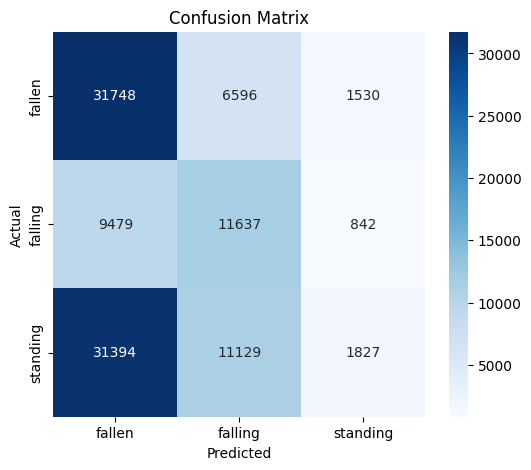

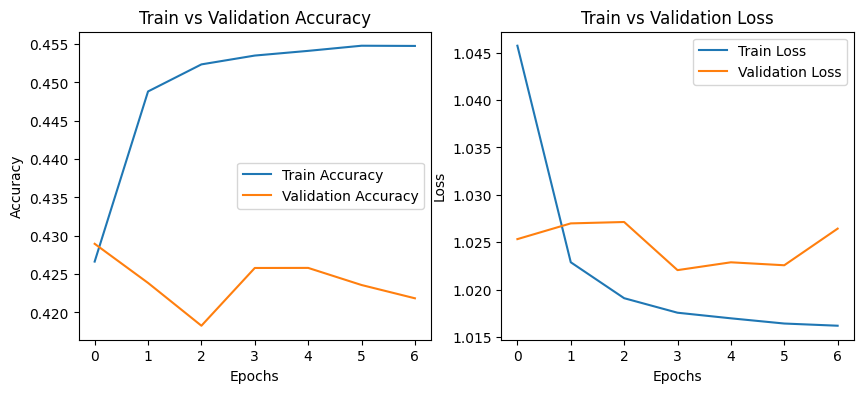

✅ 정확도(Accuracy): 0.4258
✅ 'falling' 클래스에 대한 재현율(Recall): 0.5300

🔍 Classification Report:
               precision    recall  f1-score   support

      fallen       0.44      0.80      0.56     39874
     falling       0.40      0.53      0.45     21958
    standing       0.44      0.04      0.08     44350

    accuracy                           0.43    106182
   macro avg       0.42      0.46      0.36    106182
weighted avg       0.43      0.43      0.34    106182



In [11]:
from imblearn.over_sampling import SMOTE

# 7. Feature Selection (Random Forest)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

selected_features = np.array(numerical_columns)[selector.get_support()]
print(f"🔍 선택된 Feature: {selected_features}")

# 8. SMOTE 적용 (Oversampling)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# 9. One-Hot Encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# CNN+LSTM 모델 개선
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_resampled.shape[1], 1)), 
    BatchNormalization(),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train_resampled_categorical.shape[1], activation='softmax')
])

# Adam 옵티마이저 학습률 조정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train_resampled, y_train_resampled_categorical, 
                    validation_data=(X_test_selected, y_test_categorical), 
                    epochs=25, batch_size=64, verbose=1, callbacks=[early_stopping])

# 모델 평가
y_pred = model.predict(X_test_selected)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
falling_recall = recall_score(y_true_classes, y_pred_classes, labels=[falling_index], average='weighted')

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 학습 및 검증 정확도 & 손실 그래프
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.show()

# 결과 출력
print(f"✅ 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ 'falling' 클래스에 대한 재현율(Recall): {falling_recall:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
